### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

In [2]:
model_name = 'model-22-lgb-wo-per-area-long-2'

### Params

In [3]:
is_log_target = True
is_per_area_target = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

#cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_num_add = ['building_per_land_area']
cols_cat_add = ['encoded_latlon']

#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [4]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
    
    return df

In [5]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)

In [6]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [7]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [8]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)
train.head(5)
test.head(5)

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv(f'dataset/id_cv{i}.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

### Preprocessing

In [9]:
train = pre_processing(train, cols_num, cols_cat)
test = pre_processing(test, cols_num, cols_cat)

c:\python36\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\python36\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

In [11]:
print(len(cols_num), len(cols_cat), len(cols_feats))

156 57 213


In [12]:
# PARS #
N_feats_rm = 35
# PARS #

from vars_03 import score_base, shuffle_results

feat_imp = pd.DataFrame({'feats': shuffle_results[:,0],
                         'avg':shuffle_results[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
print(len(feats_rm))
print(feats_rm)

print('N feats (before):', len(cols_feats))
cols_feats = list(set(cols_feats) - set(feats_rm))
print('N feats (after):', len(cols_feats))
print(cols_feats)

[[0 'XIII_index_500' 5524.196631427719 1.6666614648256655]
 [1 'VI_500' 5524.196588360582 1.6666183976885804]
 [2 'IX_index_50' 5523.863284797632 1.3333148347392125]
 [3 'I_50' 5523.529966556772 0.9999965938786772]
 [4 'III_index_50' 5523.52993208159 0.9999621186971126]
 [5 'XIV_100' 5523.529795207054 0.999825244161002]
 [6 'X_50' 5523.196637563681 0.6666676007880596]
 [7 'VI_index_500' 5523.196626105514 0.6666561426209228]
 [8 'VIII_index_50' 5523.19662525478 0.6666552918868547]
 [9 'XI_index_1000' 5523.196624752728 0.6666547898348654]
 [10 'XIII_250' 5523.196536159863 0.6665661969700523]
 [11 'N_500' 5523.196516711289 0.6665467483962857]
 [12 'XIII_index_50' 5522.863304462509 0.33333449961628503]
 [13 'I_index_1000' 5522.863304129733 0.3333341668394496]
 [14 'I_10' 5522.8633036210485 0.33333365815542493]
 [15 'IV_index_1000' 5522.863299346049 0.3333293831556148]
 [16 'VIII_index_1000' 5522.863298332599 0.3333283697056686]
 [17 'IX_index_1000' 5522.863297587239 0.33332762434565666]
 [

### Params
Enter best params from `build`

In [13]:
# params
params = dict((
    ('task', 'train'), 
    ('boosting_type', 'gbdt'), 
    ('objective', 'mse'), 
    ('metric', 'mape'), 
    ('learning_rate', 0.0008), 
    ('max_depth', 22), 
    ('num_leaves', 255), 
    ('feature_fraction', 0.4), 
    ('min_data_in_leaf', 6), 
    ('lambda_l1', 0.04), 
    ('lambda_l2', 0.02),
    ('max_bin', 511),
    ('min_sum_hessian_in_leaf', 0.01),
    ('seed', 777)
))

lgb_other_params = {'num_boost_round': 1000000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                    'keep_training_booster': True,}

### kfold cross-predict

In [14]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
best_iterations = []
scores = []; mapes = []
for i, id_fold in enumerate(id_cv):
    #id_fold = id_fold['building_id']
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy()
    df_val = train.loc[train['building_id'].isin(id_fold)].copy()
    df_test = test.copy()
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_target], reference=lgb_train).construct()
        
    # train model    
    model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)
    best_iterations.append(model.best_iteration)

    # Predict on val set
    y_pred = model.predict(df_val[cols_feats])
    mse = mean_squared_error(df_val[col_target], y_pred)
    mae = mean_absolute_error(df_val[col_target], y_pred)
    mape = cal_mape(df_val[col_target], y_pred)
    mapes.append(mape)
    
    y_pred_final = post_processing(y_pred, df_val)
    score = cal_score(df_val['total_price'], y_pred_final)
    scores.append(score)

    print('(Fold %d) score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (i, score, mse, mae, mape))
    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'total_price': df_val['total_price'],
                                      'total_price_predict': y_pred_final}))

    # Predict on test set
    y_pred_test = model.predict(df_test[cols_feats])
    predicts_test['target_{}'.format(i)] = y_pred_test

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0204285
[4000]	valid_0's mape: 0.0123335
[6000]	valid_0's mape: 0.0104164
[8000]	valid_0's mape: 0.00968693
[10000]	valid_0's mape: 0.00929938
[12000]	valid_0's mape: 0.00906268
[14000]	valid_0's mape: 0.00889909
[16000]	valid_0's mape: 0.00877783
[18000]	valid_0's mape: 0.00868622
[20000]	valid_0's mape: 0.00861381
[22000]	valid_0's mape: 0.00855493
[24000]	valid_0's mape: 0.00850643
[26000]	valid_0's mape: 0.00846614
[28000]	valid_0's mape: 0.00843263
[30000]	valid_0's mape: 0.00840399
[32000]	valid_0's mape: 0.00837863
[34000]	valid_0's mape: 0.00835617
[36000]	valid_0's mape: 0.00833643
[38000]	valid_0's mape: 0.00831842
[40000]	valid_0's mape: 0.00830211
[42000]	valid_0's mape: 0.00828762
[44000]	valid_0's mape: 0.0082745
[46000]	valid_0's mape: 0.00826203
[48000]	valid_0's mape: 0.00825031
[50000]	valid_0's mape: 0.00823958
[52000]	valid_0's mape: 0.00822997
[54000]	valid_0's mape: 0.0082214


[134000]	valid_0's mape: 0.00814685
[136000]	valid_0's mape: 0.0081458
[138000]	valid_0's mape: 0.00814472
[140000]	valid_0's mape: 0.00814375
[142000]	valid_0's mape: 0.00814285
[144000]	valid_0's mape: 0.00814197
[146000]	valid_0's mape: 0.00814115
[148000]	valid_0's mape: 0.00814036
[150000]	valid_0's mape: 0.00813963
[152000]	valid_0's mape: 0.00813893
[154000]	valid_0's mape: 0.00813821
[156000]	valid_0's mape: 0.00813756
[158000]	valid_0's mape: 0.00813691
[160000]	valid_0's mape: 0.00813635
[162000]	valid_0's mape: 0.0081357
[164000]	valid_0's mape: 0.00813517
[166000]	valid_0's mape: 0.0081346
[168000]	valid_0's mape: 0.00813411
[170000]	valid_0's mape: 0.00813367
[172000]	valid_0's mape: 0.00813318
[174000]	valid_0's mape: 0.00813272
[176000]	valid_0's mape: 0.00813225
[178000]	valid_0's mape: 0.00813181
[180000]	valid_0's mape: 0.00813136
[182000]	valid_0's mape: 0.00813098
[184000]	valid_0's mape: 0.00813058
[186000]	valid_0's mape: 0.00813024
[188000]	valid_0's mape: 0.0081

[266000]	valid_0's mape: 0.00814125
[268000]	valid_0's mape: 0.00814114
[270000]	valid_0's mape: 0.00814106
[272000]	valid_0's mape: 0.00814097
[274000]	valid_0's mape: 0.00814089
[276000]	valid_0's mape: 0.0081408
[278000]	valid_0's mape: 0.00814073
[280000]	valid_0's mape: 0.00814064
[282000]	valid_0's mape: 0.00814055
[284000]	valid_0's mape: 0.00814047
[286000]	valid_0's mape: 0.00814038
[288000]	valid_0's mape: 0.00814029
[290000]	valid_0's mape: 0.00814021
[292000]	valid_0's mape: 0.00814012
[294000]	valid_0's mape: 0.00814005
[296000]	valid_0's mape: 0.00813996
[298000]	valid_0's mape: 0.00813989
[300000]	valid_0's mape: 0.00813982
[302000]	valid_0's mape: 0.00813976
[304000]	valid_0's mape: 0.00813969
[306000]	valid_0's mape: 0.00813963
[308000]	valid_0's mape: 0.00813957
[310000]	valid_0's mape: 0.00813951
[312000]	valid_0's mape: 0.00813945
[314000]	valid_0's mape: 0.00813939
[316000]	valid_0's mape: 0.00813935
[318000]	valid_0's mape: 0.0081393
[320000]	valid_0's mape: 0.008

[68000]	valid_0's mape: 0.00812854
[70000]	valid_0's mape: 0.00812351
[72000]	valid_0's mape: 0.00811874
[74000]	valid_0's mape: 0.00811435
[76000]	valid_0's mape: 0.0081102
[78000]	valid_0's mape: 0.00810601
[80000]	valid_0's mape: 0.00810232
[82000]	valid_0's mape: 0.00809898
[84000]	valid_0's mape: 0.00809585
[86000]	valid_0's mape: 0.00809277
[88000]	valid_0's mape: 0.00808989
[90000]	valid_0's mape: 0.00808721
[92000]	valid_0's mape: 0.00808453
[94000]	valid_0's mape: 0.00808195
[96000]	valid_0's mape: 0.00807967
[98000]	valid_0's mape: 0.0080775
[100000]	valid_0's mape: 0.00807544
[102000]	valid_0's mape: 0.00807359
[104000]	valid_0's mape: 0.00807178
[106000]	valid_0's mape: 0.00807008
[108000]	valid_0's mape: 0.00806854
[110000]	valid_0's mape: 0.00806711
[112000]	valid_0's mape: 0.00806566
[114000]	valid_0's mape: 0.00806438
[116000]	valid_0's mape: 0.00806306
[118000]	valid_0's mape: 0.00806181
[120000]	valid_0's mape: 0.00806055
[122000]	valid_0's mape: 0.00805938
[124000]	v

In [15]:
print('Total run time:', time.time() - t0)

Total run time: 54983.40087080002


In [16]:
print('Kfold cv score (mean, stdev, all):', np.mean(scores), np.std(scores), scores) # 5724.469598319313
print('Kfold cv mape (mean, stdev, all):', np.mean(mapes), np.std(mapes), mapes)

Kfold cv score (mean, stdev, all): 5753.070671055953 40.11563423169209 [5691.872010636091, 5774.87080256527, 5808.868535004533, 5727.8720614819695, 5761.869945591903]
Kfold cv mape (mean, stdev, all): 0.008097101466912338 3.831988464687258e-05 [0.008091110415205513, 0.008110740204891628, 0.00812773088981429, 0.008130161714188032, 0.008025764110462229]


In [17]:
predicts_test.head()

,building_id,target_0,target_1,target_2,target_3,target_4
0,X5gsdTWGS3W7JJQB,16.325394,16.286099,16.370164,16.284143,16.324207
1,BTshNOJyKHnT2YIT,15.174076,15.179511,15.190255,15.186818,15.187469
2,dhdymr0lV8N5kZOT,16.239704,16.269658,16.262876,16.221672,16.296397
3,VEwyGGMcD56w5BOc,15.574532,15.553992,15.541208,15.571521,15.591568
4,wmUeMoJZfsqaSX9b,13.840971,13.775986,13.758290,13.822141,13.834506


In [18]:
pd.concat(predicts_val, axis=0).to_csv('output/'+model_name+'-cv.csv', index=False)

predicts_test['target_mean'] = \
    predicts_test[['target_'+str(i) for i in range(len(id_cv))]].mean(axis=1)
predicts_test['total_price'] = post_processing(predicts_test['target_mean'].values, df_test)
predicts_test[['building_id', 'total_price']].to_csv('output/'+model_name+'-test-kfold.csv', index=False)

In [19]:
print('Best iterations:', best_iterations)
print('Mean best iterations:', int(np.mean(best_iterations)))

Best iterations: [315872, 317136, 320967, 317456, 322175]
Mean best iterations: 318721


### One-fold test

In [23]:
lgb_other_params_one = {'num_boost_round': int(np.mean(best_iterations)*1.15),
                        'verbose_eval': 2000,
                        'keep_training_booster': True,}
lgb_other_params_one

{'keep_training_booster': True,
 'num_boost_round': 366529,
 'verbose_eval': 2000}

In [24]:
params

{'boosting_type': 'gbdt',
 'feature_fraction': 0.4,
 'lambda_l1': 0.04,
 'lambda_l2': 0.02,
 'learning_rate': 0.0008,
 'max_bin': 511,
 'max_depth': 22,
 'metric': 'mape',
 'min_data_in_leaf': 6,
 'min_sum_hessian_in_leaf': 0.01,
 'num_leaves': 255,
 'objective': 'mse',
 'seed': 777,
 'task': 'train'}

In [25]:
df_train = train.copy()
df_test = test.copy()

# feat eng
feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
df_train = feat_eng.fit_transform(df_train)
df_test = feat_eng.transform(df_test)

# Construct lgb dataset
lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()

# train model    
model = lgb.train(params, lgb_train, valid_sets=lgb_train, **lgb_other_params_one)

y_pred = model.predict(df_test[cols_feats])
y_pred_final = post_processing(y_pred, df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': y_pred_final})
display(df_test_pred.head(20))

[2000]	training's mape: 0.019433
[4000]	training's mape: 0.0105684
[6000]	training's mape: 0.00815369
[8000]	training's mape: 0.00704078
[10000]	training's mape: 0.00632005
[12000]	training's mape: 0.00578487
[14000]	training's mape: 0.00535821
[16000]	training's mape: 0.00500138
[18000]	training's mape: 0.00469448
[20000]	training's mape: 0.00442795
[22000]	training's mape: 0.00419449
[24000]	training's mape: 0.00398648
[26000]	training's mape: 0.00379777
[28000]	training's mape: 0.00362587
[30000]	training's mape: 0.0034679
[32000]	training's mape: 0.00332143
[34000]	training's mape: 0.00318468
[36000]	training's mape: 0.00305578
[38000]	training's mape: 0.00293638
[40000]	training's mape: 0.00282291
[42000]	training's mape: 0.00271619
[44000]	training's mape: 0.00261578
[46000]	training's mape: 0.00252071
[48000]	training's mape: 0.00243081
[50000]	training's mape: 0.00234528
[52000]	training's mape: 0.00226425
[54000]	training's mape: 0.00218717
[56000]	training's mape: 0.00211357


,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.201060e+07
1,BTshNOJyKHnT2YIT,3.933533e+06
2,dhdymr0lV8N5kZOT,1.146014e+07
3,VEwyGGMcD56w5BOc,5.778982e+06
4,wmUeMoJZfsqaSX9b,9.995482e+05
5,EtBjGAHmHCe9t7TZ,2.768558e+06
6,hPNH34vmaZtvBtqc,1.213603e+07
7,wXjeI38bYDMJJwZC,6.330192e+06
8,fxZSGX6aPAFKU8W4,1.669445e+06
9,ewr0Fx6ign87OwaV,4.145853e+06


In [26]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

### Feature importance

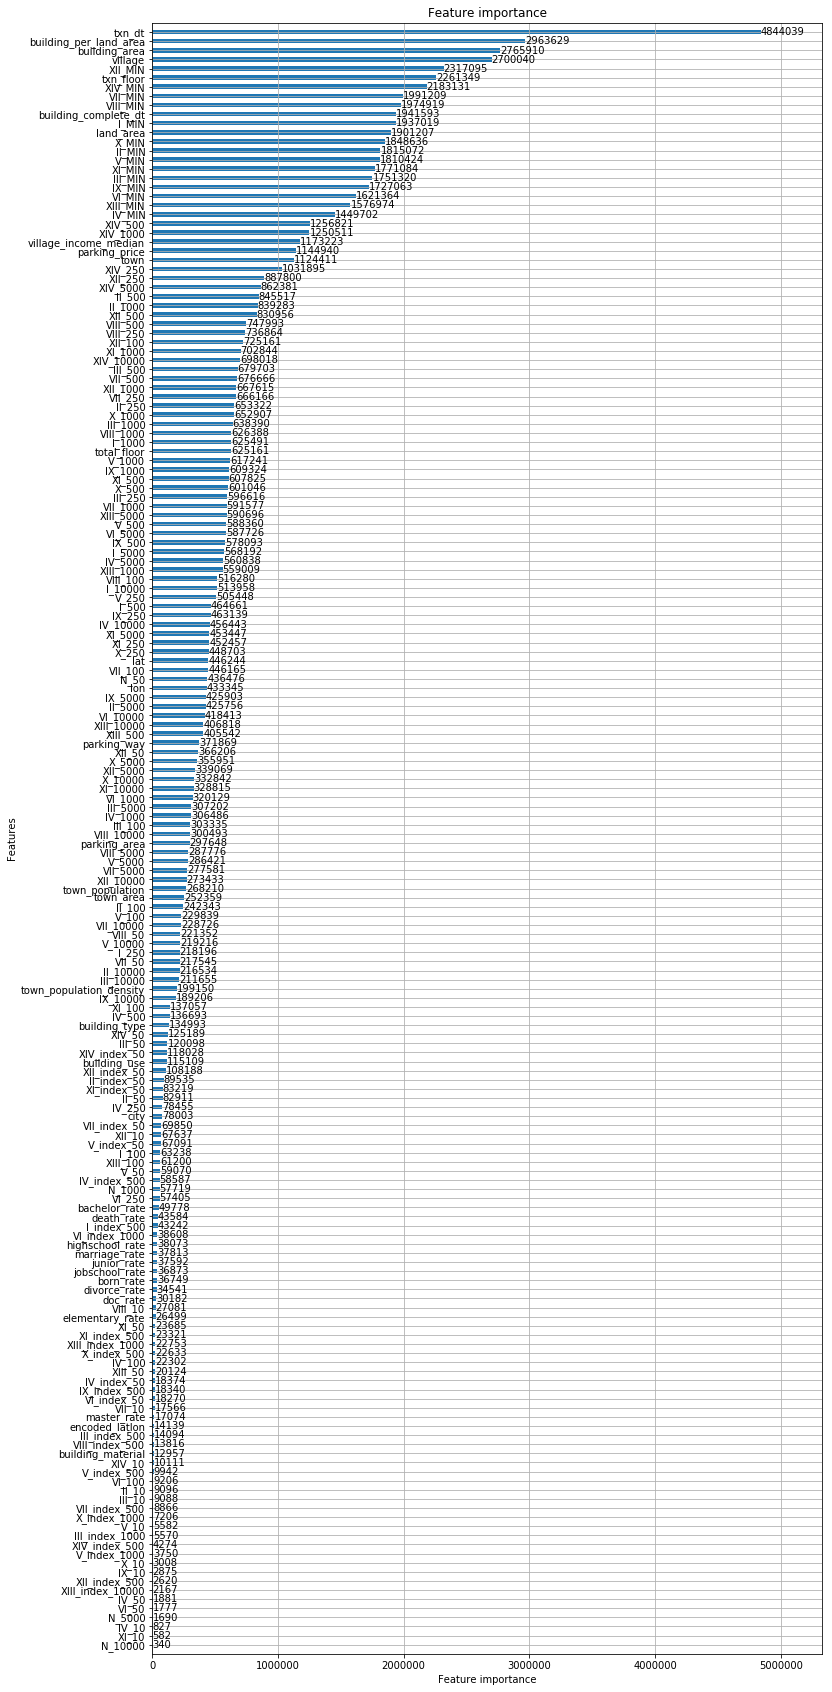

In [27]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

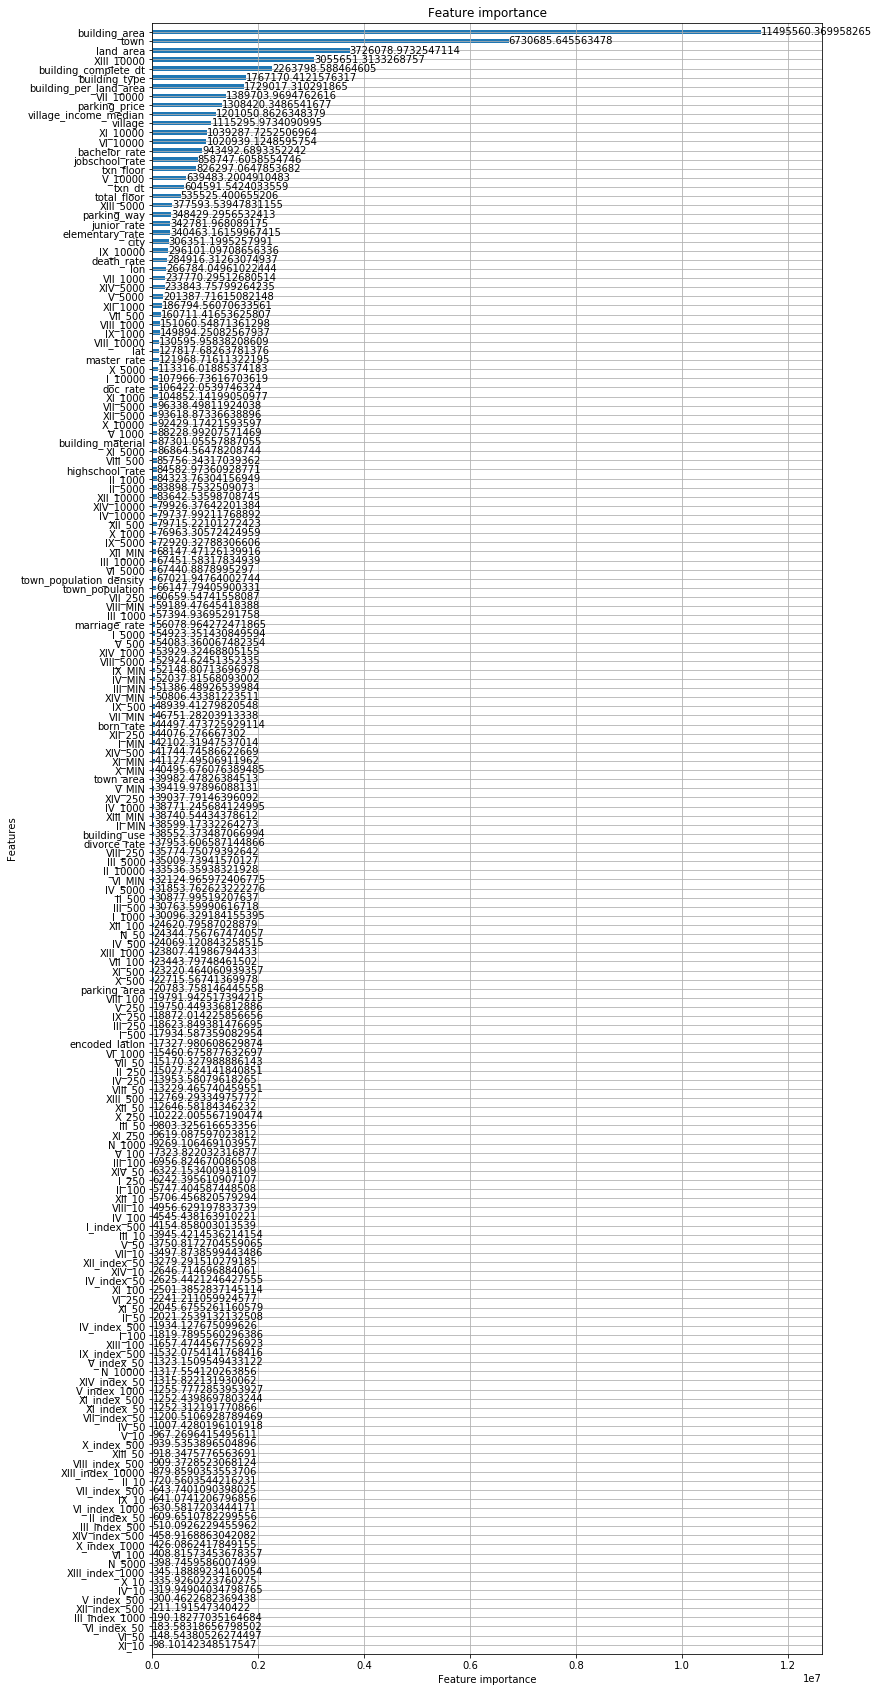

In [28]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()

### LB scores:
- kfold = 
- one = 